In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.8.13 (default, Mar 28 2022, 06:13:39) 
[Clang 12.0.0 ]
Running on numpy v1.22.1


Create Synthetic Rainbow + Transit

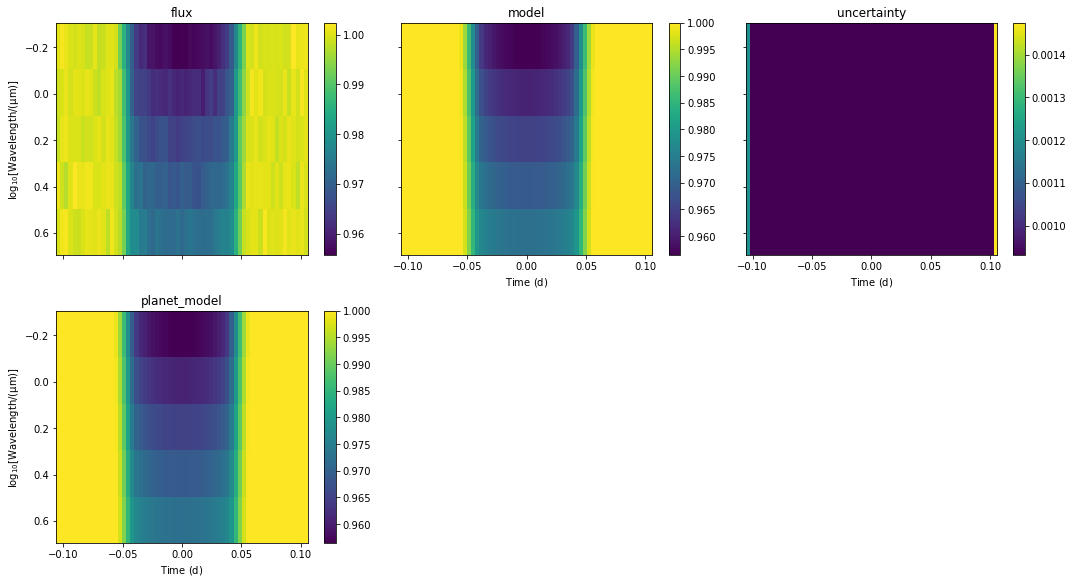

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit:
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

rbin5.imshow_quantities();

## Fit with PyMC3 Transit Model

Create a transit model

In [3]:
# create transit model:
t = TransitModel()

# add empty pymc3 model:
t.initialize_empty_model()

# add our parameters:
t.setup_parameters(
                  period=1, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), # I will keep this fixed for when we add a polynomial model!
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') for each wavelength 🧮>



Now we can attach the data and setup the model!

In [4]:
# attach the Rainbow object to the model:
t.attach_data(rbin5)

# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20145.55it/s]


Let's check the model has the parameters we expect:

In [5]:
print(t.pymc3_model)

                epoch_interval__ ~ TransformedDistribution
       impact_parameter_impact__ ~ TransformedDistribution
       stellar_radius_interval__ ~ TransformedDistribution
         stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_w0_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w0 ~ Normal
                     baseline_w0 ~ Normal
limb_darkening_w1_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w1 ~ Normal
                     baseline_w1 ~ Normal
limb_darkening_w2_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w2 ~ Normal
                     baseline_w2 ~ Normal
limb_darkening_w3_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w3 ~ Normal
                     baseline_w3 ~ Normal
limb_darkening_w4_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w4 ~ Normal
                     baseline_w4 ~ Normal
                           epoch ~ Uniform
      

Now we can plot a couple of priors - do they look OK?


🌈 Warning: invalid value encountered in log

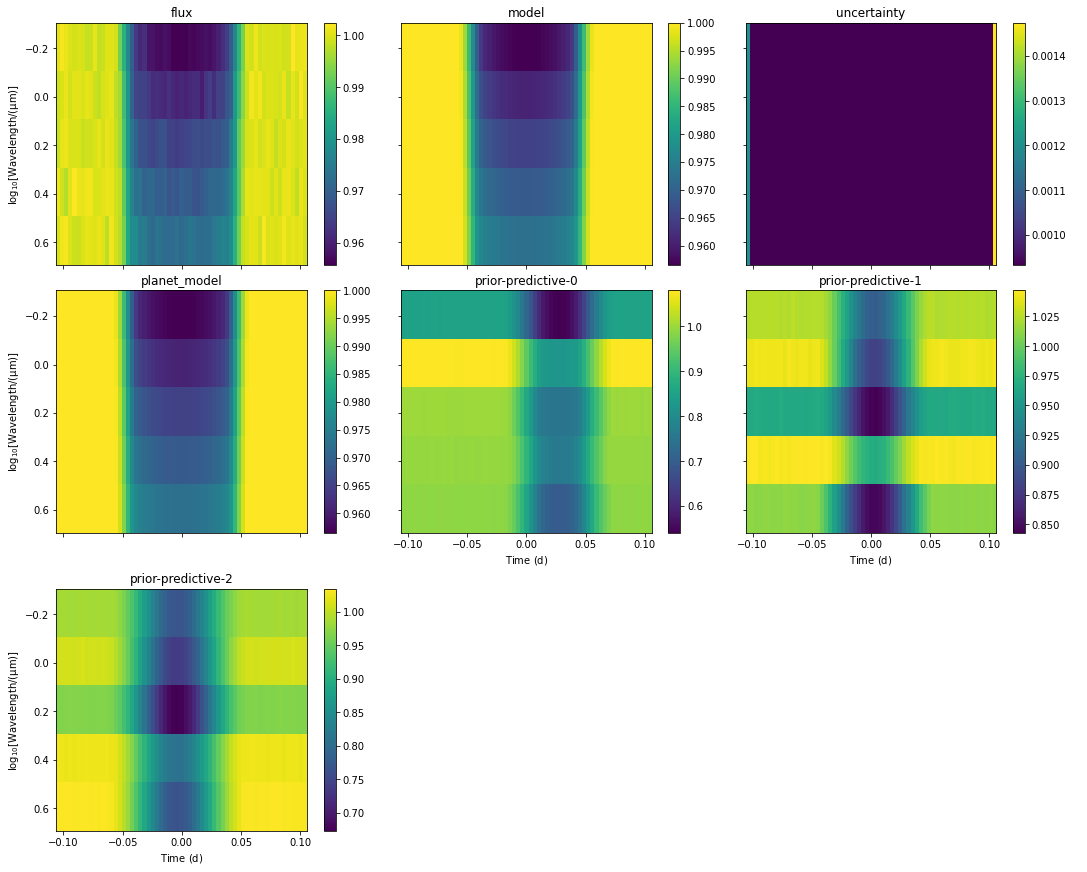

In [6]:
t.plot_priors()

Another check is does the orbit look good?

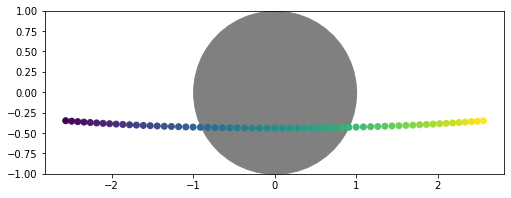

In [7]:
t.plot_orbit()

Finally, if we're happy, we can try sampling! This can take a while if there's lots of parameters!

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.summarize() before calling this step!


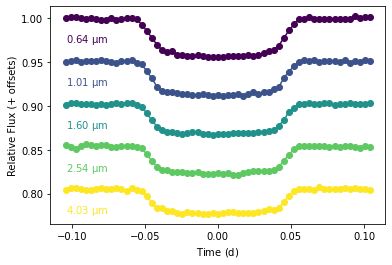

In [8]:
t.plot_lightcurves()

In [9]:
t.plot_lightcurves

<bound method LightcurveModel.plot_lightcurves of <chromatic transit model 🌈>>

In [10]:
t.sample(tune=2000, draws=2000, chains=4, cores=4)


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w4, radius_ratio_w4, limb_darkening_w4, baseline_w3, radius_ratio_w3, limb_darkening_w3, baseline_w2, radius_ratio_w2, limb_darkening_w2, baseline_w1, radius_ratio_w1, limb_darkening_w1, baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass, stellar_radius, impact_parameter, epoch]



🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppfSampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 161 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


We might want to see a summary table of the MCMC sampling results:

In [11]:
t.summarize(round_to=7, fmt='wide')

                          mean        sd    hdi_3%   hdi_97%  mcse_mean  \
radius_ratio_w0       0.196648  0.001006  0.194756  0.198503   0.000015   
baseline_w0           0.999913  0.000176  0.999600  1.000261   0.000002   
radius_ratio_w1       0.186970  0.001010  0.185136  0.188890   0.000016   
baseline_w1           0.999999  0.000174  0.999678  1.000330   0.000002   
radius_ratio_w2       0.176063  0.001074  0.174158  0.178157   0.000022   
...                        ...       ...       ...       ...        ...   
transit_model_w4[56]  1.000205  0.000173  0.999887  1.000535   0.000003   
transit_model_w4[57]  1.000205  0.000173  0.999887  1.000535   0.000003   
transit_model_w4[58]  1.000205  0.000173  0.999887  1.000535   0.000003   
transit_model_w4[59]  1.000205  0.000173  0.999887  1.000535   0.000003   
transit_model_w4[60]  1.000205  0.000173  0.999887  1.000535   0.000003   

                       mcse_sd     ess_bulk     ess_tail     r_hat  
radius_ratio_w0       0.000010

We might also want to see a couple of posterior samples as a "quick-look" check!


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

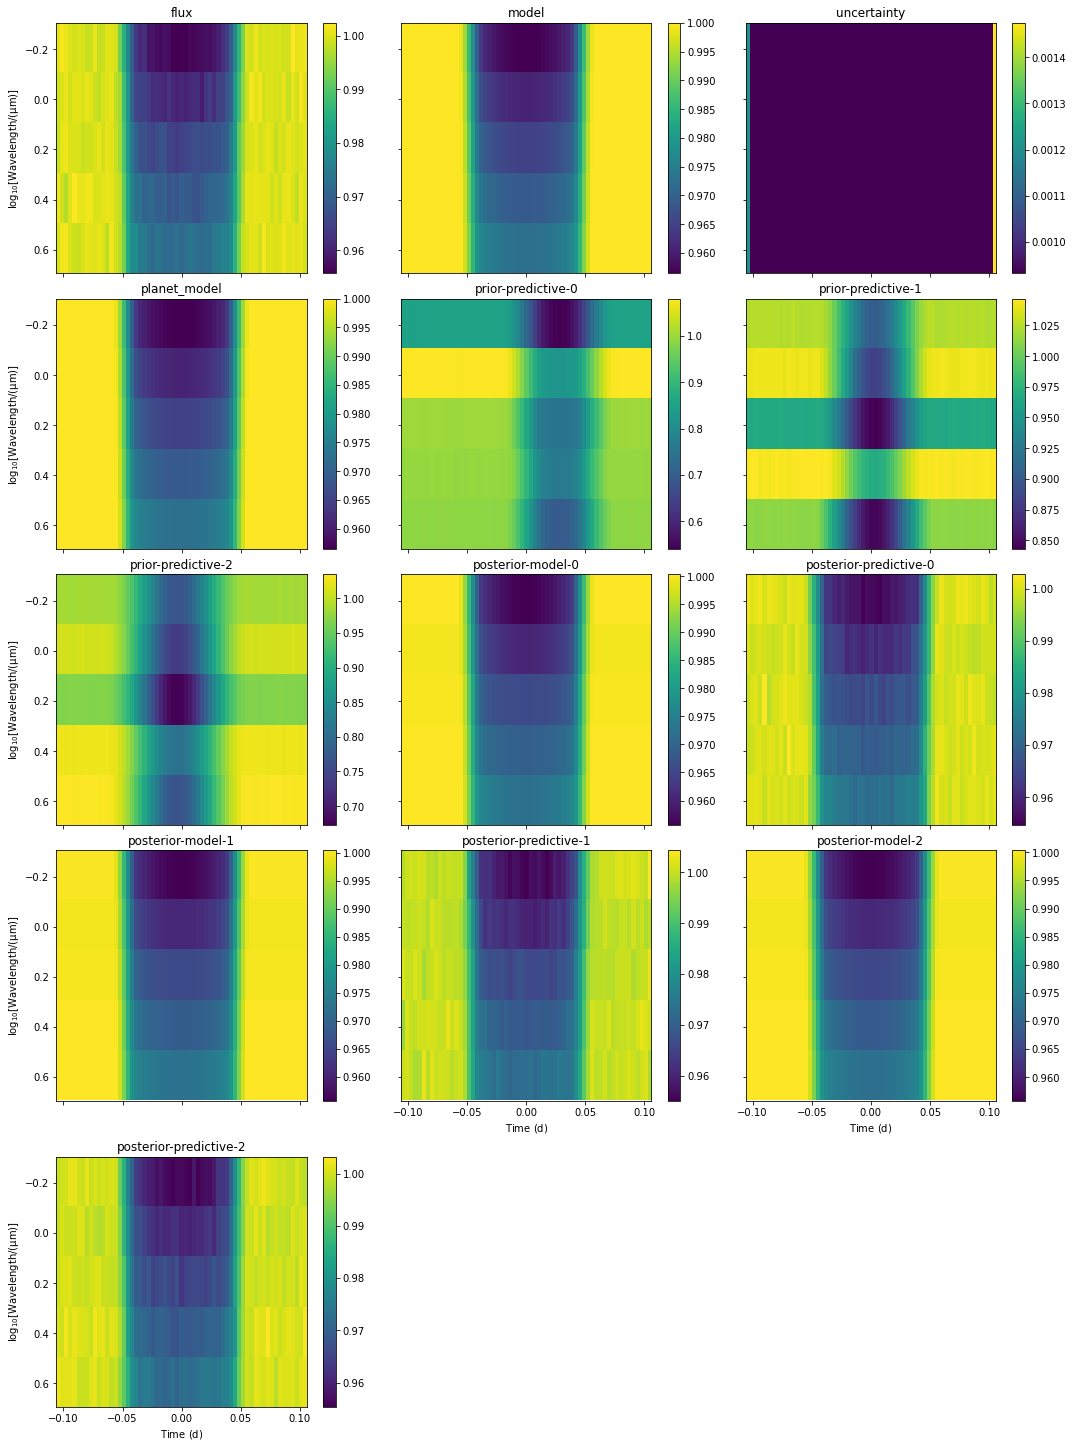

In [12]:
t.plot_posteriors()

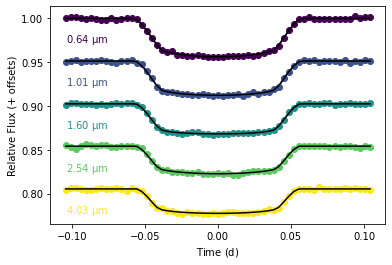

In [13]:
t.plot_lightcurves()


🌈 Warning: 'systematics_model' doesn't exist and will be skipped.

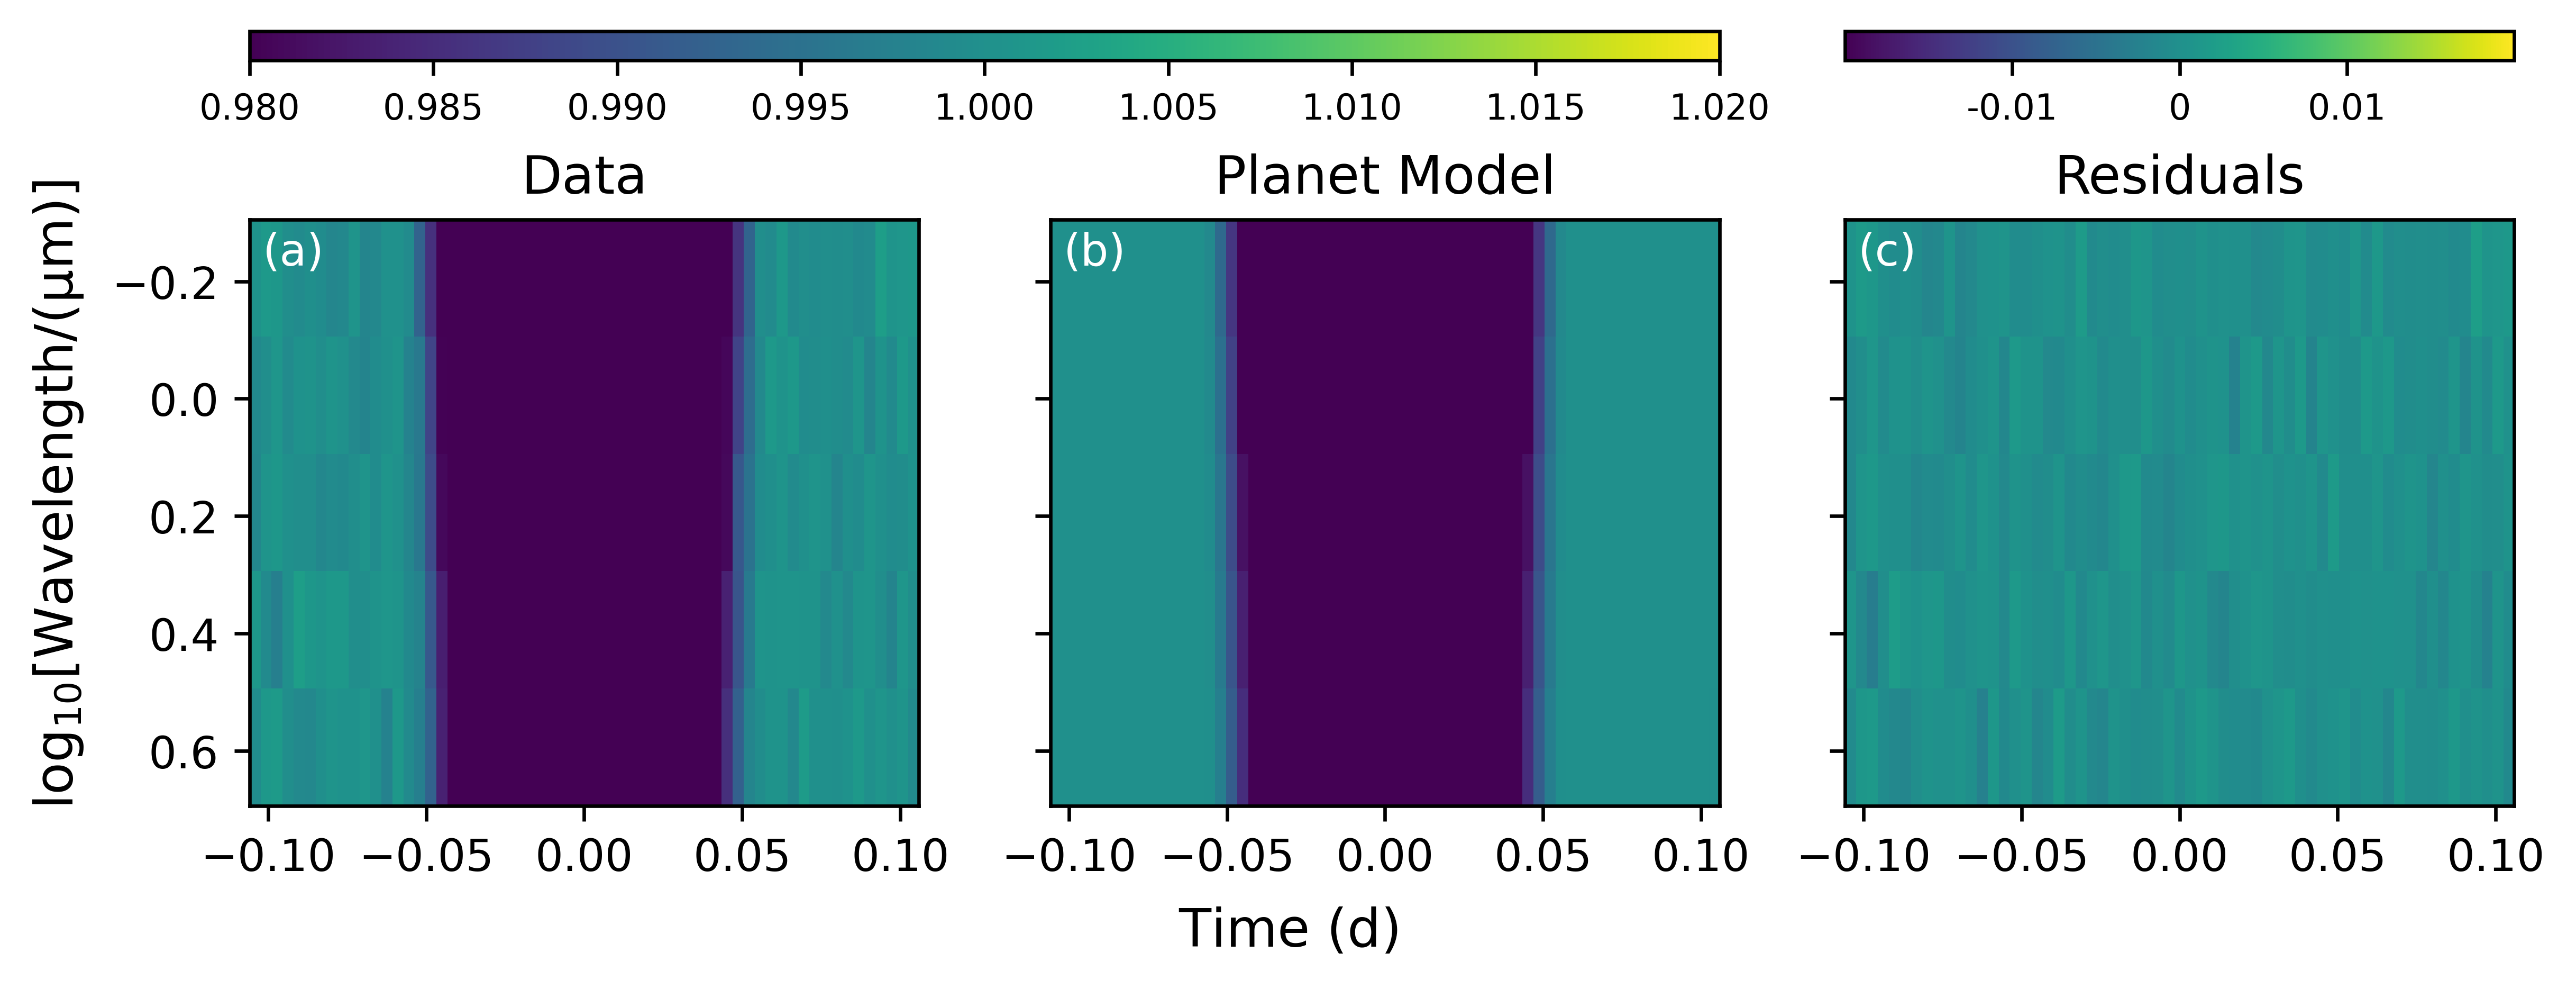

In [14]:
t.imshow_with_models()